In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
data_folder = 'expr_data'

In [17]:
import time
t = time.time()

## Environment Setup (for Colab)

In [ ]:
from datetime import datetime

os.chdir('/content')
current_time = datetime.utcnow().isoformat().replace(':', '_')
os.makedirs(os.path.join(current_time))
os.chdir(f'./{current_time}')
WORKSPACE = 'anonify'

!git clone https://github.com/lng-ng/anonify.git

os.chdir(f'./{WORKSPACE}')

!pip install numpy
!pip install pandas
!pip install -r expr_requirements.txt

## Run the experiment

In [4]:
import pandas as pd
import os
import numpy as np
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn import tree
from sklearn.neighbors import KNeighborsClassifier
from sklearn import svm
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier, BaggingClassifier, RandomForestClassifier
import tqdm
import warnings
import matplotlib.pyplot as plt

from stratified_sampling import random_deletion

warnings.filterwarnings('ignore')

In [5]:
n_times = 10
# Number of times the sampling process is run, default is 10
# Lower this to make the experiment faster

In [6]:
SA_NAMES = ['hypertension', 'heart_disease', 'smoking_history', 'HbA1c_level', 'blood_glucose_level', 'diabetes']
QID_NAMES = ['gender', 'age', 'bmi']
k1, k2, k3, k4 = 'Accuracy', 'Recall', 'Precision', 'F1 Score'

In [7]:
# Helper functions
def interval_transform(x):
    try:
        return float(x)
    except ValueError:
        if x == '*': return 0
        interval_vals = x.split('-')
        return (float(interval_vals[0]) + float(interval_vals[1])) * 0.5


def get_metrics(y_test, y_pred):
    f1 = f1_score(y_test, y_pred, average="weighted") * 100
    prec = precision_score(y_test, y_pred, average="weighted") * 100
    rec = recall_score(y_test, y_pred, average="weighted") * 100
    acc = accuracy_score(y_test, y_pred) * 100
    return acc, prec, rec, f1


def eval_classifiers(df, test_size):
    # Label Encode
    gender_encoder = [['Female', 'Male', '*', 'Other'], np.arange(4)]
    smoking_encoder = [['never', 'No Info', 'current', 'not current', 'ever', 'former'],
                       np.arange(6)]
    df['gender'] = df['gender'].replace(gender_encoder[0], gender_encoder[1])
    df['smoking_history'] = df['smoking_history'].replace(smoking_encoder[0], smoking_encoder[1])
    numerical_encode = ['age', 'bmi']
    for attr in numerical_encode:
        df[attr] = df[attr].apply(interval_transform)

    # Split Train/Test
    x = df.drop(columns=['diabetes'])
    y = df['diabetes']
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=test_size, random_state=35)
    res_df = pd.DataFrame(columns=[k1,k2,k3,k4])

    # Naive Bayes
    gnb = GaussianNB()
    y_pred = gnb.fit(x_train, y_train).predict(x_test)
    res_df.loc['Naive Bayes'] = get_metrics(y_test, y_pred)

    # Decision Tree
    clftree = tree.DecisionTreeClassifier()
    y_pred = clftree.fit(x_train, y_train).predict(x_test)
    res_df.loc['Decision Tree'] = get_metrics(y_test, y_pred)

    # KNN
    knn = KNeighborsClassifier(n_neighbors=5)
    y_pred = knn.fit(x_train, y_train).predict(x_test)
    res_df.loc['KNN'] = get_metrics(y_test, y_pred)

    # SVM
    # rbf kernel
    rbfsvm = svm.SVC(kernel="rbf")
    y_pred = rbfsvm.fit(x_train, y_train).predict(x_test)
    res_df.loc['SVM'] = get_metrics(y_test, y_pred)

    # RF
    rftree = RandomForestClassifier(n_estimators=100)
    y_pred = rftree.fit(x_train, y_train).predict(x_test)
    res_df.loc['Random Forest'] = get_metrics(y_test, y_pred)

    # LR
    logReg = LogisticRegression()
    y_pred = logReg.fit(x_train, y_train).predict(x_test)
    res_df.loc['Logistic Regression'] = get_metrics(y_test, y_pred)

    # AdaBoost
    adaboost = AdaBoostClassifier()
    y_pred = adaboost.fit(x_train, y_train).predict(x_test)
    res_df.loc['AdaBoost'] = get_metrics(y_test, y_pred)

    # Bagging
    bg = BaggingClassifier()
    y_pred = bg.fit(x_train, y_train).predict(x_test)
    res_df.loc['Bagging'] = get_metrics(y_test, y_pred)

    return res_df


In [8]:
# Load datasets
load_path_original = os.path.join(data_folder, 'diabetes_prediction_dataset.csv')
load_path_anonymized = os.path.join(data_folder, 'diabetes_anonymized_arx250.csv')
dfo = pd.read_csv(load_path_original)
#dfo = dfo.drop(columns='RID')
df = pd.read_csv(load_path_anonymized)
#df = df.drop(columns='RID')

In [9]:
test_size = 0.25 # Split train/test 75/25
dfs = {
    'Original Dataset': eval_classifiers(dfo, test_size),
    'Only K-Anonymity': eval_classifiers(df, test_size)
}

# Sampling process
ps = [0.1, 0.3, 0.5, 0.7]
for p in ps:
    print(f"-- Deletion percentage: {p} --")
    print(f"-- Sampling the dataset {n_times} times --")
    avg_res = 0
    for i in tqdm.tqdm(range(n_times)):
        sampled_df = random_deletion(df, p, QID_NAMES)
        eval_res = eval_classifiers(sampled_df, test_size)
        avg_res += eval_res
    avg_res /= n_times
    dfs[f"Deletion-{p} (average)"] = avg_res

-- Deletion percentage: 0.1 --
-- Sampling the dataset 2 times --


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [01:16<00:00, 38.40s/it]


-- Deletion percentage: 0.3 --
-- Sampling the dataset 2 times --


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:48<00:00, 24.43s/it]


-- Deletion percentage: 0.5 --
-- Sampling the dataset 2 times --


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:28<00:00, 14.13s/it]


-- Deletion percentage: 0.7 --
-- Sampling the dataset 2 times --


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:13<00:00,  6.54s/it]


In [10]:
def gen_plot(metrics, metric_key):
    data = metrics[metric_key]
    # Sample data
    subjects = ["NB", "DT", "KNN", "SVM", "RF", "LR", "AB", "BG"]
    original = data['Original Dataset']
    anonymized = data['Only K-Anonymity']
    sampling90 = data["Deletion-0.1 (average)"]
    sampling70 = data["Deletion-0.3 (average)"]
    sampling50 = data["Deletion-0.5 (average)"]
    sampling30 = data["Deletion-0.7 (average)"]
    
    # Set the width of the bars
    bar_width = 0.1
    
    # Create an array of subject positions for the x-axis
    subject_positions = np.arange(len(subjects))
    
    # Create the grouped bar chart
    bar_positions = [subject_positions + i * bar_width for i in range(6)]
    
    # Set the new x-axis labels
    group_labels = ["Original", "Anonymized", "Sampling90", "Sampling70", "Sampling50", "Sampling30"]
    
    plt.figure(figsize=(8, 6))
    # Create the grouped bars for each dataset
    for i, data in enumerate([original, anonymized, sampling90, sampling70, sampling50, sampling30]):
        plt.bar(bar_positions[i], data, bar_width, label=group_labels[i])
    
    # Set x-axis labels
    plt.xticks(subject_positions + 2.5 * bar_width, subjects, fontsize=12)
    
    # Set the chart labels and title
    plt.xlabel('Classifiers', fontsize=12)
    plt.ylabel(metric_key, fontsize=12)
    #plt.title('Accuracy Comparison by Dataset and Classifier')
    
    # Add a legend
    plt.legend(loc='lower right', fontsize=12)
    
    # Display the chart
    plt.show()


In [11]:
metrics = {
    k1: pd.DataFrame(),
    k2: pd.DataFrame(),
    k3: pd.DataFrame(),
    k4: pd.DataFrame(),
}
for df_k, df_data in dfs.items():
    for metric_k, metric_df in metrics.items():
        metric_df.insert(len(metric_df.columns), df_k, df_data[metric_k])

## Figure 10: Accuracy

,Original Dataset,Only K-Anonymity,Deletion-0.1 (average),Deletion-0.3 (average),Deletion-0.5 (average),Deletion-0.7 (average)
Naive Bayes,89.932,90.264,90.174838,90.714572,90.330717,90.560235
Decision Tree,95.116,95.580,95.682445,95.600435,95.375561,95.066185
KNN,95.288,95.588,95.573450,95.503175,95.259449,95.092927
SVM,94.876,94.704,94.803808,94.639281,94.298527,94.063377
Random Forest,97.052,96.560,96.625589,96.721780,96.652787,96.811071
Logistic Regression,95.204,95.760,95.920456,95.720579,95.147341,95.781522
AdaBoost,97.184,97.144,97.255094,97.242405,97.141256,97.198823
Bagging,96.768,96.320,96.307501,96.487213,96.452594,96.483487


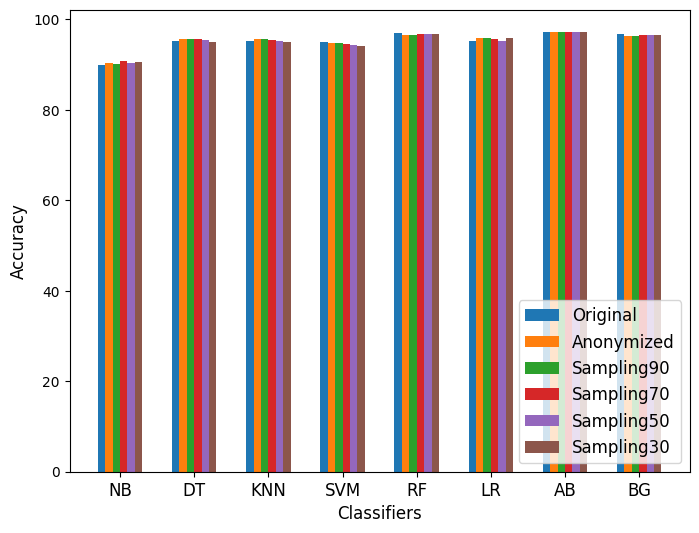

In [12]:
display(metrics[k1])
gen_plot(metrics, k1)

## Figure 13: Recall

,Original Dataset,Only K-Anonymity,Deletion-0.1 (average),Deletion-0.3 (average),Deletion-0.5 (average),Deletion-0.7 (average)
Naive Bayes,92.185213,92.107576,92.059300,92.384936,92.100225,92.246291
Decision Tree,95.274348,95.534175,95.660644,95.622191,95.416840,95.241024
KNN,94.968413,95.413679,95.348527,95.264837,94.978443,94.834015
SVM,95.147054,94.994180,95.082925,94.936554,94.633049,94.426719
Random Forest,96.998934,96.393986,96.462040,96.571157,96.497469,96.682785
Logistic Regression,94.822846,95.559426,95.674022,95.451568,94.765395,95.528554
AdaBoost,97.173268,97.177473,97.270567,97.244941,97.156527,97.222488
Bagging,96.620511,96.140260,96.141140,96.322486,96.277080,96.319514


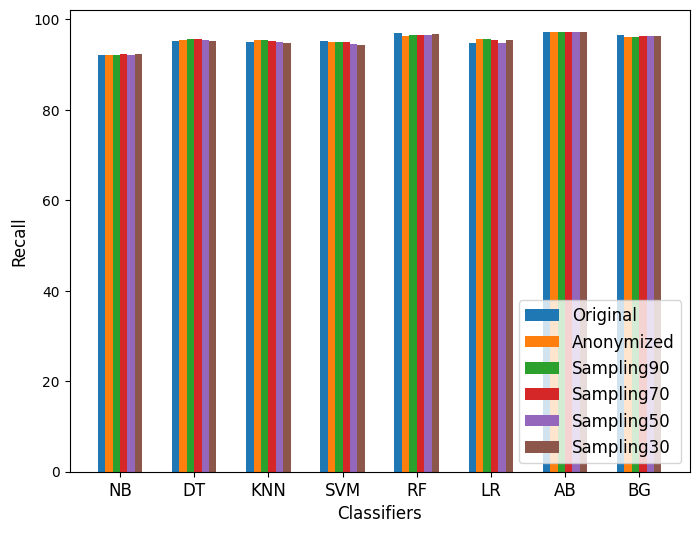

In [13]:
display(metrics[k2])
gen_plot(metrics, k2)

## Figure 14: Precision

,Original Dataset,Only K-Anonymity,Deletion-0.1 (average),Deletion-0.3 (average),Deletion-0.5 (average),Deletion-0.7 (average)
Naive Bayes,89.932,90.264,90.174838,90.714572,90.330717,90.560235
Decision Tree,95.116,95.580,95.682445,95.600435,95.375561,95.066185
KNN,95.288,95.588,95.573450,95.503175,95.259449,95.092927
SVM,94.876,94.704,94.803808,94.639281,94.298527,94.063377
Random Forest,97.052,96.560,96.625589,96.721780,96.652787,96.811071
Logistic Regression,95.204,95.760,95.920456,95.720579,95.147341,95.781522
AdaBoost,97.184,97.144,97.255094,97.242405,97.141256,97.198823
Bagging,96.768,96.320,96.307501,96.487213,96.452594,96.483487


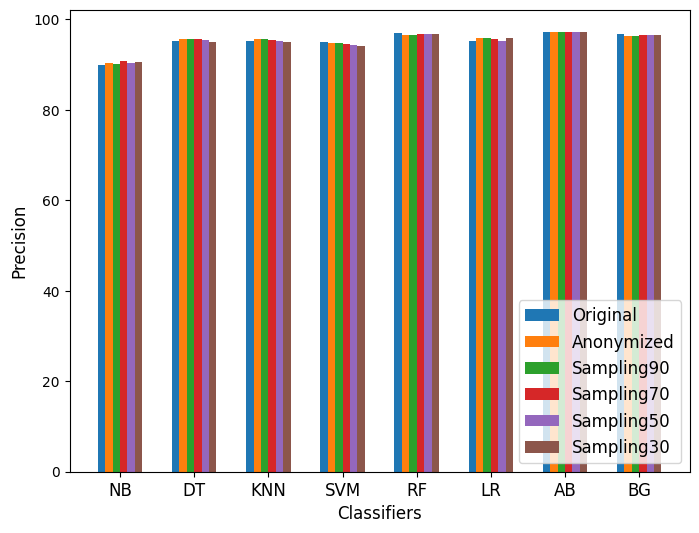

In [14]:
display(metrics[k3])
gen_plot(metrics, k3)

## Figure 15: F1 Score

,Original Dataset,Only K-Anonymity,Deletion-0.1 (average),Deletion-0.3 (average),Deletion-0.5 (average),Deletion-0.7 (average)
Naive Bayes,90.831170,91.008113,90.940855,91.390016,91.052498,91.239576
Decision Tree,95.188090,95.556063,95.671302,95.611103,95.395533,95.144345
KNN,94.727137,95.076699,95.075120,95.002679,94.691106,94.474574
SVM,93.793649,93.608377,93.723242,93.489518,92.951635,92.640721
Random Forest,96.826414,96.395840,96.465064,96.558461,96.463034,96.639311
Logistic Regression,94.884753,95.333948,95.601660,95.388851,94.790721,95.533385
AdaBoost,96.958478,96.905108,97.036920,97.031704,96.905402,96.979430
Bagging,96.575943,96.176408,96.188658,96.355122,96.300213,96.342894


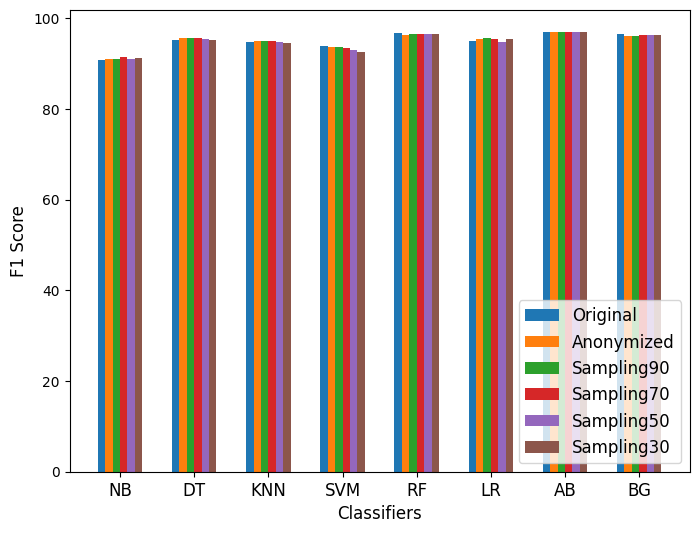

In [15]:
display(metrics[k4])
gen_plot(metrics, k4)

In [16]:
# cleanup data folder
#import shutil
#shutil.rmtree(data_folder)

In [ ]:
print(f"Time taken: {time.time() - t}")